<p style="font-size:11px;"><em><strong>Créditos</strong>: El contenido de este cuaderno ha sido tomado de varias fuentes, pero especialmente de <a href="http://darribas.org/">Dani Arribas-Bel</a> - University of Liverpool & <a href="http://spatial.ucr.edu/peopleRey.html">Sergio Rey</a> - Center for Geospatial Sciences, University of California, Riverside. El compilador se disculpa por cualquier omisión involuntaria y estaría encantado de agregar un reconocimiento.</em></p>

# Análisis de datos areales: mapas

## Coropletas

Los mapas coropléticos juegan un papel importante en la ciencia de datos geográficos, ya que nos permiten mostrar atributos o variables no geográficas en un mapa geográfico. La palabra coroplético proviene de la raíz "coro", que significa "región". Como tal, los mapas coropléticos representan datos a nivel de región y son apropiados para datos de unidades areales donde cada observación combina un valor de un atributo y una figura geométrica, generalmente un polígono. Los mapas coropléticos derivan de una era anterior en la que los cartógrafos enfrentaban limitaciones tecnológicas que impedían el uso de mapas sin clasificar, donde cada valor único de un atributo podría estar representado por un símbolo o color distinto. En su lugar, los valores de los atributos se agrupaban en un número menor de clases, usualmente no más de 12. Cada clase se asociaba con un símbolo único que, a su vez, se aplicaba a todas las observaciones con valores de atributos dentro de esa clase.

Aunque hoy en día estas limitaciones tecnológicas ya no son un obstáculo, y los mapas sin clasificar son factibles, aún hay buenas razones para adoptar un enfoque clasificado. La principal de ellas es reducir la carga cognitiva que implica analizar la complejidad de un mapa sin clasificar. Un mapa coroplético reduce esta complejidad al basarse en la teoría estadística y de visualización para proporcionar una representación efectiva de la distribución espacial de los valores de los atributos a través de las unidades areales.

La efectividad de un mapa coroplético dependerá de la elección del esquema de clasificación junto con la estrategia de color o simbolización adoptada. En términos generales, el esquema de clasificación define el número de clases, así como las reglas para la asignación, mientras que la simbolización debe transmitir información sobre la diferenciación de los valores a través de las clases.

En este capítulo primero discutimos los enfoques utilizados para clasificar los valores de los atributos. Esto es seguido por una visión general de la teoría del color y las implicaciones de los diferentes esquemas de color para un diseño de mapas efectivo. Combinamos teoría y práctica al explorar cómo se implementan estos conceptos en diferentes paquetes de Python, incluyendo `geopandas` y `PySAL`.

En esta sesión, construiremos sobre todo lo que hemos aprendido hasta ahora sobre la carga y manipulación de datos (espaciales) y lo aplicaremos a una de las formas más comúnmente utilizadas de análisis espacial: los coropletas. Recuerden que estos son mapas que muestran la distribución espacial de una variable codificada en un esquema de colores, también llamado paleta. Aunque existen muchas formas de convertir los valores de una variable en un color específico, en este contexto nos centraremos solo en algunas de ellas, en particular:

- Valores únicos
- Intervalo igual
- Cuantiles
- Fisher-Jenks

In [1]:
import seaborn as sbn
import geopandas as gpd

print(gpd.datasets.available)

['naturalearth_cities', 'naturalearth_lowres', 'nybb']


In [2]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.head()

C:\Users\edier\AppData\Local\Temp\ipykernel_3392\2976061603.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


C:\Users\edier\AppData\Local\Temp\ipykernel_3392\970683425.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  h = sbn.distplot(gdf['pop_est'], bins=5, rug=True);


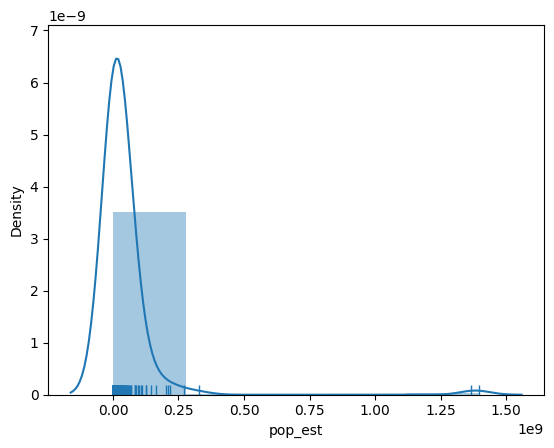

In [3]:
h = sbn.distplot(gdf['pop_est'], bins=5, rug=True);

In [4]:
gdf['pop_est'].describe()

count    1.770000e+02
mean     4.324346e+07
std      1.513543e+08
min      1.400000e+02
25%      3.301000e+06
50%      1.019232e+07
75%      3.182530e+07
max      1.397715e+09
Name: pop_est, dtype: float64

Para atributos cuantitativos, primero ordenamos los datos por su valor, de modo que $x₀ ≤ x₂ … ≤ xₙ₋₁$. Para un número preestablecido de clases k, el problema de clasificación se reduce a la selección de k−1 puntos de corte a lo largo de los valores ordenados que separan los valores en grupos mutuamente excluyentes y exhaustivos.

De hecho, la determinación del histograma anterior puede verse como un enfoque para esta selección. El método `seaborn.distplot` utiliza la función `hist` de `matplotlib` en segundo plano para determinar los límites de las clases y el conteo de observaciones en cada clase. En la figura, tenemos cinco clases que pueden extraerse con una llamada explícita a la función `hist`:


In [5]:
counts, bins, patches = h.hist(gdf['pop_est'], bins=5)

El objeto `counts` captura cuántas observaciones tiene cada categoría en la clasificación:

In [6]:
counts

array([174.,   1.,   0.,   0.,   2.])

The bin object stores these break points we are interested in when considering classification schemes (the patches object can be ignored in this context, as it stores the geometries of the histogram plot):

In [7]:
bins

array([1.40000000e+02, 2.79543112e+08, 5.59086084e+08, 8.38629056e+08,
       1.11817203e+09, 1.39771500e+09])

Esto produce 5 clases, donde la primera tiene un límite inferior de 140 y un límite superior de 2.758e+08, que contiene 1 observación. La determinación del ancho del intervalo ($w$) y el número de clases en `seaborn` se basa en la regla de Freedman-Diaconis:

$$
w = 2 * IQR * n^{-1/3}
$$

donde $IQR$ es el rango intercuartílico de los valores del atributo. Dado $w$, el número de clases ($k$) es:

$$k=(max - min)/w.$$

A continuación, presentamos varios enfoques para crear estos puntos de corte que siguen criterios que pueden ser de interés en diferentes contextos, ya que se centran en diferentes prioridades.


### Equal Intervals

The Freedman-Diaconis approach provides a rule to determine the width and, in
turn, the number of bins for the classification. This is a special case of a
more general classifier known as "equal intervals", where each of the bins has
the same width in the value space. For a given value of $k$, equal intervals
classification splits the range of the attribute space into $k$ equal length
intervals, with each interval having a width $w = \frac{x_0 - x_{n-1}}{k}$. Thus
the maximum class is $(x_{n-1}-w, x_{n-1}]$ and the first class is $(-\infty,
x_{n-1} - (k-1)w]$.

Equal intervals have the dual advantages of simplicity and ease of
interpretation. However, this rule only considers the extreme values of the
distribution and, in some cases, this can result in one or more classes being
sparse. This is clearly the case in our income dataset, as the majority of the
values are placed into the first two classes leaving the last three classes
rather sparse:

In [8]:
ei5 = mapclassify.EqualInterval(gdf['pop_est'], k=5)
ei5

NameError: name 'mapclassify' is not defined

Cabe destacar que cada uno de los intervalos, sin embargo, tiene un ancho igual de $w = 4093.8$. Este valor de $k = 5$ también coincide con la clasificación predeterminada en el histograma de Seaborn mostrado en la Figura 1. También debe señalarse que la primera clase está cerrada en el límite inferior, en contraste con el enfoque general definido en la Ecuación (1).


### Cuantiles

Para evitar el posible problema de clases dispersas, se pueden utilizar los cuantiles de la distribución para identificar los límites de las clases. De hecho, cada clase tendrá aproximadamente $\mid\frac{n}{k}\mid$ observaciones usando el clasificador de cuantiles. Si $k=5$, se utilizan los quintiles de la muestra para definir los límites superiores de cada clase, lo que resulta en la siguiente clasificación:


In [ ]:
q5 = mapclassify.Quantiles(gdf.pop_est, k=5)
q5

In [ ]:
Cabe señalar que, aunque el número de valores en cada clase es aproximadamente igual, los anchos de los primeros cuatro intervalos son bastante diferentes:


In [ ]:
q5.bins[1:]-q5.bins[:-1]

Aunque los cuantiles evitan el problema de clases escasas, esta clasificación no está exenta de problemas. Los anchos variables de los intervalos pueden ser marcadamente diferentes, lo que puede llevar a problemas de interpretación. Un segundo desafío que enfrentan los cuantiles surge cuando hay un gran número de valores duplicados en la distribución, lo que puede hacer que los límites de una o más clases se vuelvan ambiguos. Por ejemplo, si se tiene una variable con $n=20$ pero 10 de las observaciones toman el mismo valor, que además es el mínimo observado, entonces para valores de $k>2$, los límites de las clases se vuelven mal definidos, ya que una simple regla de división en el valor observado de rango $n/k$ dependería de cómo se traten los empates al clasificar.


### Media-desviación estándar

Nuestro tercer clasificador utiliza la media muestral $\bar{x} =
\frac{1}{n} \sum_{i=1}^n x_i$ y la desviación estándar muestral $s = \sqrt{
\frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})  }$ para definir los límites de las clases como
una distancia desde la media muestral, siendo esta distancia un múltiplo de la
desviación estándar. Por ejemplo, una definición común para $k=5$ es fijar
el límite superior de la primera clase a dos desviaciones estándar ($c_{0}^u = \bar{x} - 2 s$), y que las clases intermedias
tengan límites superiores dentro de una desviación estándar ($c_{1}^u = \bar{x}-s,\ c_{2}^u = \bar{x}+s, \ c_{3}^u
= \bar{x}+2s$). Cualquier valor mayor (o menor) que dos desviaciones estándar por encima (o por debajo) de la media
se colocará en la clase superior (o inferior).


In [ ]:
msd = mapclassify.StdMean(gdf['pop_est'])
msd

Este clasificador es mejor utilizado cuando los datos se distribuyen de manera normal o, al menos, cuando la media muestral es una medida significativa para anclar la clasificación. Claramente, este no es el caso para nuestros datos de ingresos, ya que la asimetría positiva resulta en una pérdida de información cuando utilizamos la desviación estándar. La falta de simetría lleva a un límite superior inadmisible para la primera clase, así como a una concentración de la gran mayoría de los valores en la clase media.


### Máximas Rupturas (Natural break)

El clasificador de máximas rupturas decide dónde establecer los puntos de corte entre
las clases considerando la diferencia entre los valores ordenados. Es decir, en lugar de considerar un valor del conjunto de datos por sí mismo, analiza cuán separados están entre sí cada valor y el siguiente en la secuencia ordenada. El clasificador luego coloca los $k-1$ puntos de corte entre los pares de valores más alejados entre sí en toda la secuencia, procediendo en orden descendente en relación con el tamaño de las rupturas:


In [ ]:
mb5 = mapclassify.MaximumBreaks(gdf['pop_est'], k=5)
mb5

Las máximas rupturas son un enfoque apropiado cuando estamos interesados en asegurarnos de que las observaciones en cada clase estén separadas de aquellas en las clases vecinas. Por lo tanto, funciona bien en casos donde la distribución de los valores no es unimodal. Además, el algoritmo es relativamente rápido de calcular. Sin embargo, su simplicidad puede causar a veces resultados inesperados. En la medida en que solo considera las $k-1$ diferencias más grandes entre valores consecutivos, otras diferencias y disimilitudes más matizadas dentro de los grupos pueden ser ignoradas.


### Box-Plot

La clasificación mediante diagrama de caja (box-plot) es una combinación de los clasificadores de cuantiles y de desviación estándar. Aquí $k$ se predefine a seis, con el límite superior de la clase 0 fijado en $q_{0.25}-h \, IQR$. $IQR = q_{0.75}-q_{0.25}$ es el rango intercuartílico; $h$ corresponde al multiplicador del $IQR$ para obtener los límites de los bigotes (whiskers). El límite inferior de la sexta clase se fija en $q_{0.75}+h \, IQR$. Las clases intermedias tienen sus límites superiores fijados en los percentiles 0.25, 0.50 y 0.75 de los valores del atributo.


In [ ]:
bp = mapclassify.BoxPlot(gdf['pop_est'])
bp

Cualquier valor que caiga en una de las clases extremas se define como un valor atípico (outlier). Cabe destacar que, dado que los valores de ingresos son no negativos por definición, la clase de outliers inferiores tiene un límite superior inadmisible, lo que significa que no sería posible tener valores atípicos inferiores en esta muestra.

El valor predeterminado para el multiplicador $h$ es $h=1.5$ en PySAL. Sin embargo, esto puede ser especificado por el usuario para una clasificación alternativa:


In [ ]:
bp1 = mapclassify.BoxPlot(gdf['pop_est'], hinge=1)
bp1

Hacer esto afectará la definición de las clases de outliers, así como las clases internas vecinas.



### Head-Tail Breaks

El algoritmo de **Head-Tail** {cite}`Jiang_2013` se basa en una partición recursiva de los datos utilizando divisiones alrededor de medias iterativas. El proceso de división continúa hasta que las distribuciones dentro de cada clase ya no muestran una distribución de cola pesada, en el sentido de que hay un equilibrio entre el número de valores menores y mayores asignados a cada clase.


In [ ]:
ht = mapclassify.HeadTailBreaks(gdf['pop_est'])
ht

Para datos con una distribución de cola pesada, como las distribuciones de ley de potencias y log-normal, el clasificador de **Head-Tail Breaks** puede ser particularmente efectivo.

### Jenks Caspall

Este enfoque, al igual que los dos siguientes, aborda el desafío de la clasificación desde una perspectiva heurística, en lugar de una determinista. Originalmente propuesto por {cite}`Jenks_1971`, este algoritmo tiene como objetivo minimizar la suma de las desviaciones absolutas alrededor de las medias de las clases. El enfoque comienza con un número preestablecido de clases y un conjunto inicial arbitrario de puntos de corte, por ejemplo, utilizando quintiles. El algoritmo intenta mejorar la función objetivo considerando el movimiento de observaciones entre clases adyacentes. Por ejemplo, se consideraría mover el valor más alto del quintil inferior al segundo quintil, mientras que el valor más bajo del segundo quintil se consideraría para un posible movimiento al primer quintil. El movimiento candidato que resultara en la mayor reducción de la función objetivo se realizaría, y el proceso continúa hasta que no sean posibles más movimientos que mejoren el resultado.

In [ ]:
numpy.random.seed(12345)
jc5 = mapclassify.JenksCaspall(gdf['pop_est'], k=5)
jc5

### Fisher Jenks

El segundo algoritmo óptimo adopta un enfoque de programación dinámica para minimizar la suma de las desviaciones absolutas alrededor de las medianas de las clases. A diferencia del enfoque Jenks-Caspall, **Fisher-Jenks** garantiza producir una clasificación óptima para un número preestablecido de clases:


### Max-p

Finalmente, los clasificadores **Max-p** adoptan el algoritmo subyacente al método de construcción de regiones max-p {cite}`Duque_2011` para el caso de la clasificación de mapas. Es similar en espíritu a **Jenks-Caspall** en el sentido de que considera intercambios voraces entre clases adyacentes para mejorar la función objetivo. Sin embargo, es un enfoque heurístico, por lo que, a diferencia de **Fisher-Jenks**, no se garantiza una solución óptima:


In [ ]:
mp5 = mapclassify.MaxP(gdf['pop_est'], k=5)
mp5

### Comparación de esquemas de clasificación

Como un caso especial de agrupamiento, la definición del número de clases y los límites de las clases plantea un problema para el diseñador de mapas. Recordemos que se dijo que la regla de Freedman-Diaconis era óptima; sin embargo, dicha optimalidad requiere la especificación de una función objetivo. En el caso de Freedman-Diaconis, la función objetivo es minimizar la diferencia entre el área bajo la densidad estimada del kernel basada en la muestra y el área bajo la distribución poblacional teórica que generó la muestra.

Esta noción de ajuste estadístico es importante. Sin embargo, no es la única consideración al evaluar clasificadores para el propósito de mapas coropléticos. También es relevante la distribución espacial de los valores del atributo y la capacidad del clasificador para transmitir una idea de esa distribución espacial. Como veremos, esto no está necesariamente relacionado directamente con la distribución estadística de los valores del atributo. Volveremos a una consideración conjunta tanto de la distribución estadística como espacial de los valores del atributo en la comparación de clasificadores a continuación.

Para la clasificación de mapas, un criterio de optimalidad que se puede utilizar es una medida de ajuste. En **PySAL**, se calcula la "desviación absoluta alrededor de las medianas de las clases" (ADCM) y proporciona una medida de ajuste que permite la comparación de clasificadores alternativos para el mismo valor de $k$.

Para ver esto, podemos comparar diferentes clasificadores para $k=5$ en los datos de México:


In [ ]:
class5 = q5, ei5, ht, mb5, msd, fj5, jc5
fits = numpy.array([ c.adcm for c in class5])
data = pandas.DataFrame(fits)
data['classifier'] = [c.name for c in class5]
data.columns = ['ADCM', 'Classifier']
ax = seaborn.barplot(y='Classifier', x='ADCM', data=data)

Como era de esperar, el clasificador **Fisher-Jenks** domina a todos los demás clasificadores con $k=5$, con un ADCM de 23,729. Curiosamente, el clasificador de intervalo igual tiene un buen desempeño a pesar de los problemas asociados con su sensibilidad a los valores extremos en la distribución. El clasificador de **media-desviación estándar** tiene un ajuste muy pobre debido a la naturaleza sesgada de los datos y a la asignación concentrada de la mayoría de las observaciones en la clase central.

El ADCM proporciona una medida global de ajuste que puede ser utilizada para comparar los clasificadores alternativos. Como complemento de esta perspectiva global, puede ser revelador considerar cómo se clasificó cada una de las observaciones espaciales en los distintos enfoques. Para hacer esto, podemos añadir el atributo de clase (yb) generado por los clasificadores de **PySAL** como columnas adicionales en el marco de datos y presentarlas conjuntamente en una tabla:


In [ ]:
gdf['q540'] = q5.yb
gdf['ei540'] = ei5.yb
gdf['ht40'] = ht.yb
gdf['mb540'] = mb5.yb
gdf['msd40'] = msd.yb
gdf['fj540'] = fj5.yb
gdf['jc540'] = jc5.yb

gdfs = gdf.sort_values('pop_est')

In [ ]:
def highlight_values(val):
    if val==0:
        return 'background-color: %s' % '#ffffff'
    elif val==1:
        return 'background-color: %s' % '#e0ffff'
    elif val==2:
        return 'background-color: %s' % '#b3ffff'
    elif val==3:
        return 'background-color: %s' % '#87ffff'
    elif val==4:
        return 'background-color: %s' % '#62e4ff'
    else:
        return ''

In [ ]:
t = gdfs[['name', 'pop_est', 'q540', 'ei540', 'ht40', 'mb540', 'msd40', 'fj540', 'jc540']]
t.style.applymap(highlight_values)

La inspección de esta tabla revela una serie de resultados interesantes. Primero, la única ciudad que es tratada de manera consistente en todos los clasificadores con $k=5$ es **China**, que es colocada en la clase más alta por todos los clasificadores.

Finalmente, podemos considerar una vista a nivel meso de los resultados de la clasificación comparando el número de valores asignados a cada clase en los diferentes clasificadores:


In [ ]:
pandas.DataFrame({c.name: c.counts for c in class5},index=['Class-{}'.format(i) for i in range(5)])

Al hacerlo, se destacan las similitudes entre **Fisher Jenks** e **intervalos iguales**, ya que los conteos de distribución son muy similares y ambos enfoques coinciden en los 17 estados asignados a la primera clase. De hecho, la única observación que distingue a los dos clasificadores es el tratamiento de **Baja California Sur**, que se mantiene en la clase 1 en intervalos iguales, pero es asignada a la clase 2 por **Fisher Jenks**.


In [ ]:
f, ax = plt.subplots(1, figsize=(12,7))
gdf.plot(ax=ax, column='pop_est', legend=True, scheme='Quantiles', legend_kwds={'fmt':'{:.0f}'}, \
         cmap='Blues')
ax.set_axis_off()
ax.set_title('Pop_est')
plt.axis('equal')
plt.show()

## Cartogramas

Los cartogramas son mapas que representan la distribución espacial de una variable no mediante su codificación en una paleta de colores, sino modificando los objetos geográficos. Existen muchos algoritmos para distorsionar las formas de las entidades geográficas de acuerdo con los valores, algunos de ellos increíblemente complicados y complejos.

Como ejemplo de cómo crear un cartograma relativamente simple, convertiremos polígonos en puntos usando sus centroides y definiremos el tamaño del punto proporcionalmente al valor de la variable que queremos mostrar, el puntaje IMD en este caso. Adoptaremos un enfoque diferente para graficar los puntos en comparación con lo que hemos hecho hasta ahora. Esto implica primero extraer las coordenadas de los puntos:


In [ ]:
pts = np.array([(pt.x, pt.y) for pt in gdf.centroid])

pts = []
for pt in gdf.centroid:
    pts.append((pt.x, pt.y))
pts = np.array(pts)

Una vez que los hayamos extraído, podemos mostrarlos mediante el comando `plt.scatter`. Esto es equivalente a un simple `plot`, o a un bucle sobre cada punto, con la diferencia de que nos permitirá modificar el tamaño de los puntos de acuerdo con una variable:
Una vez que los hayamos extraído, podemos mostrarlos mediante el comando `plt.scatter`. Esto es equivalente a un simple `plot`, o a un bucle sobre cada punto, con la diferencia de que nos permitirá modificar el tamaño de los puntos de acuerdo con una variable:


In [ ]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot the dots, using `imd_score` as a variable to modify
# the size of each dot
ax.scatter(pts[:, 0], pts[:, 1], c='purple', s=gdf['pop_est'].values/1000000)
# Keep axes proportionate
ax.axis("equal")
# Display
plt.show()